In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [3]:
cutout_num = 200

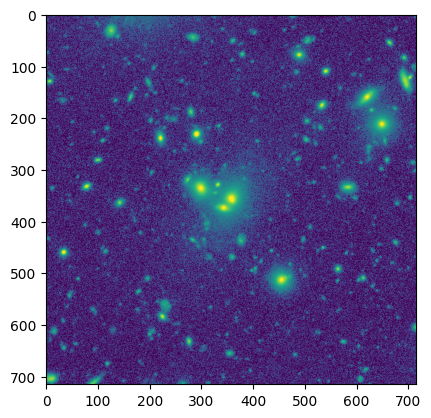

In [4]:
cutouts = h5py.File('/srv/scratch/z5214005/hsc_icl/cutouts.hdf')
cutout = cutouts[str(cutout_num)]['HDU0']['DATA']

plt.imshow(stretch(cutout))
plt.show()

Generated z=0.1919609223640191


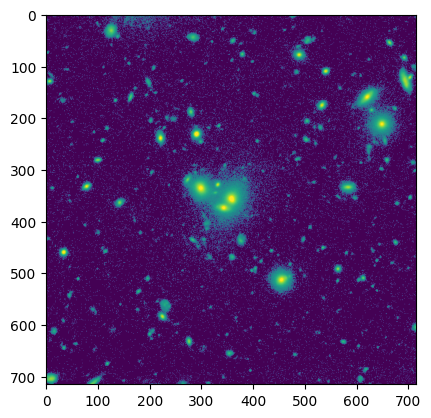

In [5]:
# Generate a threshold that corresponds to a realistic 25 mag arcsec SB.
random_z = np.random.uniform(low=0, high=0.2) # Generate between 0 and 0.2 because we would rather be too aggressive than not aggressive enough
sb_threshold = 25 + 10 * np.log10(1 + random_z)
threshold = 10**(-0.4*(sb_threshold - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

print(f'Generated z={random_z}')

# How much of the image is brighter than this threshold? 
plt.imshow(stretch(cutout) * (cutout > threshold))
plt.show()

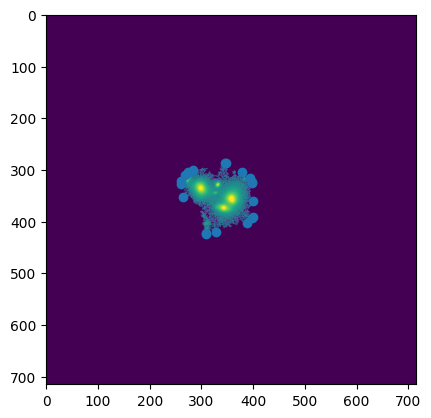

In [6]:
# Generate a fake ICL profile
from astropy.modeling.functional_models import Sersic2D
import scipy

# Use the distance from the central pixel to the edges of the central blob as r_eff
bright_parts = (cutout > threshold)
labels, _ = scipy.ndimage.label(bright_parts)
centre = (cutout.shape[0] // 2, cutout.shape[1] // 2)
central_blob = bright_parts * (labels == labels[centre[0], centre[1]])
edges = scipy.spatial.ConvexHull(np.argwhere(central_blob))

distances = scipy.spatial.distance.cdist([centre], np.argwhere(central_blob)[edges.vertices])[0]
r_eff = np.median(distances)

plt.imshow(stretch(cutout) * central_blob)
plt.scatter(np.argwhere(central_blob)[edges.vertices][:,1], np.argwhere(central_blob)[edges.vertices][:,0])
plt.show()

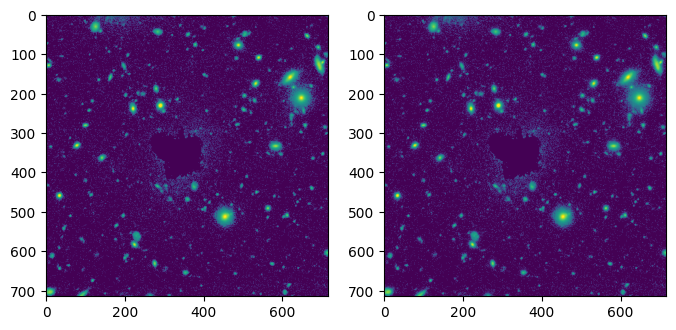

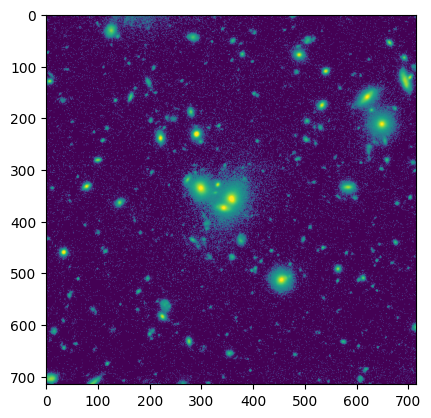

In [7]:
from astropy.convolution import Gaussian2DKernel, convolve
from skimage.morphology import binary_dilation, binary_opening

# Blur edges of other non central blob galaxies
non_central_galaxies = bright_parts * ~central_blob
kernel = Gaussian2DKernel(7)
non_central_blurred = binary_opening(non_central_galaxies)
non_central_blurred = convolve(non_central_blurred, kernel)
non_central_blurred = np.where(non_central_galaxies | central_blob, non_central_galaxies, non_central_blurred)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(non_central_galaxies * stretch(cutout))
plt.subplot(122)
plt.imshow(non_central_blurred * stretch(cutout))
plt.show()

final_bright_parts = non_central_blurred + central_blob
plt.imshow(stretch(cutout) * final_bright_parts)
plt.show()

Parameters: amplitude=0.08822069871631535, n=5, ellip=0.469800082961481, theta=1.128223271401036


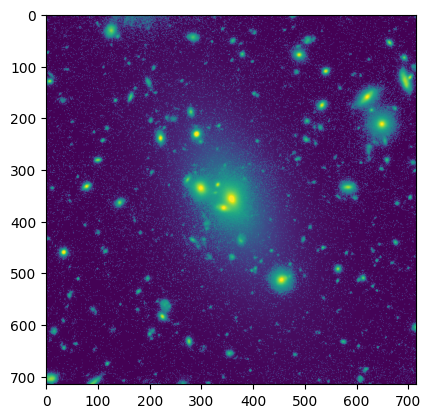

In [8]:
# Create the profile
amplitude = 10**(-0.4*(sb_threshold - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))
n = np.random.randint(low=1, high=11)
ellip = np.random.uniform(low=0, high=0.5)
theta = np.random.uniform(low=0, high=2*np.pi)

print(f'Parameters: amplitude={amplitude}, n={n}, ellip={ellip}, theta={theta}')

model = Sersic2D(amplitude=amplitude, r_eff=r_eff, n=n, x_0=centre[1], y_0=centre[0], ellip=ellip, theta=theta)
x, y = np.meshgrid(np.arange(cutout.shape[1]), np.arange(cutout.shape[0]))

# Remove the central blob
icl = np.where(central_blob, 0, model(x,y))

bright_and_icl = (cutout * final_bright_parts) + model(x,y)

plt.imshow(stretch(bright_and_icl))
plt.show()

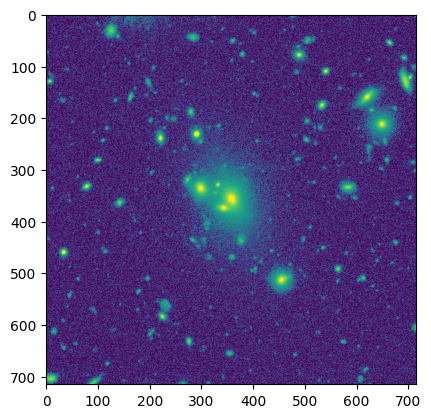

In [9]:
# Add noise to the image
std = np.std(cutout * ~bright_parts)
noise = np.random.normal(loc=0, scale=std, size=cutout.shape)

plt.imshow(stretch(bright_and_icl + noise))
plt.show()

In [10]:
# Calculate the new artificial ICL fraction
icl = np.sum(model(x,y)[model(x,y) < threshold])
print(icl)
print(np.sum(final_bright_parts))
print(np.sum(cutout * final_bright_parts))
print(np.sum(model(x,y)))
total = np.sum((cutout * final_bright_parts) + model(x, y))
print(icl / total)

2409.282355633474
79330.17336343355
26460.751653192485
6723.329193286593
0.07260355851890665


In [6]:
# Figure out the statistics of the deep images
# Surface brightness limit
from astropy.stats import mad_std
import skimage
from astropy.io import ascii

fracs = np.load('/srv/scratch/z5214005/precalc_fracs/fracs.npy')[2]
not_nans = np.where(~np.isnan(fracs))[0]

array_dud = []
for idx in not_nans:
    cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
    img = skimage.transform.resize(cutout, (715,715))
    array_dud.append(img)

array_dud = np.array(array_dud)

In [8]:
stddev = mad_std(array_dud)
print(f'Standard deviation before stretch = {stddev}')
sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)
print(f'Average surface brightness limit = {sb_lim}')

Standard deviation before stretch = 0.02903799938806964
Average surface brightness limit = 30.213053338121288


In [14]:
# How much noise to add to the generated images? 
zs = ascii.read('/srv/scratch/z5214005/camira_final.tbl')['z_cl'][:125]

stds = []
for i, cutout in enumerate(array_dud):
    cutout = skimage.transform.resize(cutout, (224,224))
    sb_threshold = 26 + 10 * np.log10(1+zs[not_nans[i]]) # Calculate mask threshold at this z
    threshold = 10**(-0.4*(sb_threshold - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168))) # Convert to counts

    # Figure out what to use as r_eff
    bright_parts = (cutout > threshold)

    std = mad_std(cutout[~bright_parts])
    stds.append(std)

print(np.mean(stds)) 

0.009526819474790857


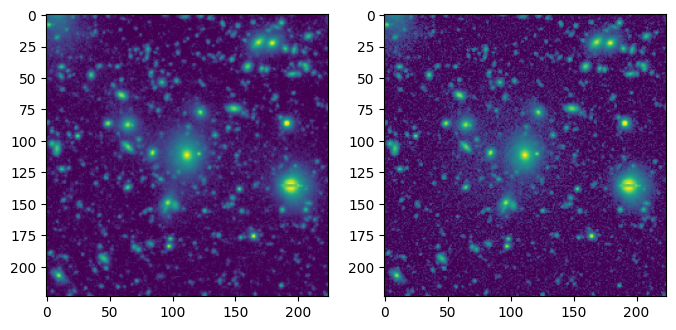

In [20]:
import sys
sys.path.append('/home/z5214005/ml_icl')
import generate_train_data
import importlib
importlib.reload(generate_train_data)
from generate_train_data import inject_icl

tbl = ascii.read('/srv/scratch/z5214005/camira_final.tbl')
tbl['z'] = tbl['z_cl']
tbl['new_ids'] = tbl['ID']
test = {}
test['2'] = {}
test['2']['HDU0'] = {}
test['2']['HDU0']['DATA'] = skimage.transform.resize(array_dud[2], (224,224))
result = inject_icl(2, test, tbl)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(stretch(skimage.transform.resize(array_dud[2], (224,224))))
plt.subplot(122)
plt.imshow(stretch(result['img']))